# Mitochondria and synapses - Figure S4

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import seaborn as sns

from scipy.stats import pearsonr, ranksums, ttest_ind

%matplotlib inline

In [20]:
timepoint = [5, 23, 27, 50, 69.5]
bound = [15, 25, 35, 47, 62]
stage_cmap = sns.color_palette("deep",8)
type_cmap = [(253/255, 225/255, 245/255),
             (1, 183/255, 139/255),
             (167/255, 217/255, 245/255)]
cmap = sns.color_palette("hls", 8)

## Load data

In [3]:
cell_df = pd.read_csv("neuron_list_hobert.csv")
cell_df.head()

,name,id,type,class,neurotransmitter1,neurotransmitter2,l1_vol,l2_vol,l3_vol,adult_vol,dauer_vol
0,ADAL,1,2,ADA,Glutamate,NaN,0.701728,1.273221,1.371940,3.494185,1.159168
1,ADAR,2,2,ADA,Glutamate,NaN,0.644497,1.260319,1.613807,2.878003,1.017088
2,ADEL,3,1,ADE,Dopamine,NaN,0.364170,1.336320,1.832287,7.324293,0.791347
3,ADER,4,1,ADE,Dopamine,NaN,0.297124,1.328579,1.841921,6.864507,0.781312
4,ADFL,5,1,ADF,Acetylcholine,Serotonin,0.753066,1.446728,2.018413,3.728548,1.827789


In [4]:
l1_mito_df = pd.read_csv("240527_dataset2_mito_neuron.csv")
l2_mito_df = pd.read_csv("240527_dataset5_mito_neuron.csv")
l3_mito_df = pd.read_csv("240527_dataset6_mito_neuron.csv")
adult_mito_df = pd.read_csv("240527_dataset8_mito_neuron.csv")
dauer_mito_df = pd.read_csv("240527_dauer1_mito_neuron.csv")
dauer_mito_df.head()

,cell_name,cell_id,cell_common_id,class,mito_id,cell_vol,mito_vol,cell_surf,mito_surf,x_pos,y_pos,z_pos,mito_len,dist_pre,dist_post
0,AIBR,15,14,2,747,2.679757,0.021658,29.616532,0.372357,5.868936,2.328813,4.282388,1.328166,0.619359,0.666193
1,AIBR,15,14,2,977,2.679757,0.022989,29.616532,0.438184,7.818976,3.981256,5.437973,0.960554,0.472862,0.581278
2,AIBR,15,14,2,1346,2.679757,0.008806,29.616532,0.194831,4.602977,2.567442,7.082849,0.874920,2.611763,0.339316
3,AIBR,15,14,2,1400,2.679757,0.020378,29.616532,0.411419,7.925869,5.646151,7.352387,1.726368,0.232002,0.817458
4,AIBR,15,14,2,2008,2.679757,0.010291,29.616532,0.250027,6.260060,7.735721,10.437065,1.414361,0.206209,0.813789


In [6]:
l1_syn_df = pd.read_csv("240527_dataset2_synapse.csv")
l2_syn_df = pd.read_csv("240527_dataset5_synapse.csv")
l3_syn_df = pd.read_csv("240527_dataset6_synapse.csv")
adult_syn_df = pd.read_csv("240527_dataset8_synapse.csv")
dauer_syn_df = pd.read_csv("240527_dauer1_synapse.csv")
dauer_syn_df.head()

,syn_id,pre,pre_id,pre_common_id,post,post_id,post_common_id,x_pos,y_pos,z_pos,size
0,1,RIH,145,124,CEPDL,187,71,6264,3540,50,56629.85685
1,1,RIH,145,124,OLQDL,189,95,6264,3540,50,115370.14310
2,2,RIH,145,124,URXR,179,181,3312,3848,50,529157.36040
3,2,RIH,145,124,IL2DR,182,88,3312,3848,50,153855.83760
4,2,RIH,145,124,CEPDR,186,72,3312,3848,50,17786.80203


In [24]:
def stderr(arr):
    
    return np.std(arr)/arr.shape[0]**0.5

def dist(x, y):
    
    x = x.reshape((-1,3))
    y = y.reshape((-1,3))
    
    return np.sum((x-y)**2, axis=1)**0.5

def get_syn_size(syn_df):
    
    syn_id_list = np.unique(syn_df["syn_id"])
    n = syn_id_list.shape[0]
    syn_size = np.zeros(n)
    for i in range(n):

        syn_id = syn_id_list[i]
        syn_loc = syn_df[syn_df["syn_id"]==syn_id][["x_pos", "y_pos", "z_pos"]].values[0,:]/1000
        cell_id = syn_df[syn_df["syn_id"]==syn_id]["pre_common_id"].values[0]

        syn_size[i] = np.sum(syn_df[syn_df["syn_id"]==syn_id]["size"])/10**9
        
    return syn_size

def get_fanout_mitodist_pre(syn_df, mito_df):
    
    syn_id_list = np.unique(syn_df["syn_id"].values)
    n =  syn_id_list.shape[0]
    
    fanout_list = np.zeros(n, dtype="uint8")
    mitodist_list = np.zeros(n)
    for i in range(n):
        
        syn_id = syn_id_list[i]
        valid = syn_df["syn_id"]==syn_id
        preid = syn_df[valid]["pre_common_id"].values[0]
        preloc = syn_df[valid][["x_pos","y_pos","z_pos"]].values/1000
        preloc = preloc[0,:]
        
        fanout_list[i] = np.sum(valid)
        
        valid = mito_df["cell_common_id"]==preid
        if np.sum(valid)==0:
            continue
            
        mito_df_valid = mito_df[valid]
        mito_loc_list = mito_df_valid[["x_pos","y_pos","z_pos"]].values
        
        dist_list = dist(mito_loc_list, preloc)
        mitodist_list[i] = np.min(dist_list)
        
    return fanout_list, mitodist_list

def get_fanout_mitodist_post(syn_df, mito_df):
    
    n =  syn_df.shape[0]
    
    fanout_list = np.zeros(n, dtype="uint8")
    mitodist_list = np.zeros(n)
    for i in range(n):
        
        syn_id = syn_df.iloc[i]["syn_id"]
        valid = syn_df["syn_id"]==syn_id
        postid = syn_df.iloc[i]["post_common_id"]
        postloc = syn_df.iloc[i][["x_pos","y_pos","z_pos"]].values/1000
        
        fanout_list[i] = np.sum(valid)
        
        valid = mito_df["cell_common_id"]==postid
        if np.sum(valid)==0 or postid==0:
            continue
            
        mito_df_valid = mito_df[valid]
        mito_loc_list = mito_df_valid[["x_pos","y_pos","z_pos"]].values
        
        dist_list = dist(mito_loc_list, postloc)
        mitodist_list[i] = np.min(dist_list)
        
    return fanout_list, mitodist_list

def get_fanout_mitovol_pre(syn_df, mito_df):
    
    syn_id_list = np.unique(syn_df["syn_id"].values)
    n =  syn_id_list.shape[0]
    
    fanout_list = np.zeros(n, dtype="uint8")
    mitovol_list = np.zeros(n)
    for i in range(n):
        
        syn_id = syn_id_list[i]
        valid = syn_df["syn_id"]==syn_id
        preid = syn_df[valid]["pre_common_id"].values[0]
        preloc = syn_df[valid][["x_pos","y_pos","z_pos"]].values/1000
        preloc = preloc[0,:]
        
        fanout_list[i] = np.sum(valid)
        
        valid = mito_df["cell_common_id"]==preid
        if np.sum(valid)==0:
            continue
            
        mito_df_valid = mito_df[valid]
        mito_loc_list = mito_df_valid[["x_pos","y_pos","z_pos"]].values
        
        dist_list = dist(mito_loc_list, preloc)
        
        if np.min(dist_list)<3:
            mitovol_list[i] = mito_df_valid.iloc[np.argmin(dist_list)]["mito_vol"]
        
    return fanout_list, mitovol_list

def get_fanout_mitovol_post(syn_df, mito_df):
    
    n = syn_df.shape[0]
    
    fanout_list = np.zeros(n, dtype="uint8")
    mitovol_list = np.zeros(n)
    for i in range(n):
        
        syn_id = syn_df.iloc[i]["syn_id"]
        valid = syn_df["syn_id"]==syn_id
        postid = syn_df.iloc[i]["post_common_id"]
        postloc = syn_df.iloc[i][["x_pos","y_pos","z_pos"]].values/1000
        
        fanout_list[i] = np.sum(valid)
        
        valid = mito_df["cell_common_id"]==postid
        if np.sum(valid)==0:
            continue
            
        mito_df_valid = mito_df[valid]
        mito_loc_list = mito_df_valid[["x_pos","y_pos","z_pos"]].values
        
        dist_list = dist(mito_loc_list, postloc)
        
        if np.min(dist_list)<3:
            mitovol_list[i] = mito_df_valid.iloc[np.argmin(dist_list)]["mito_vol"]
        
    return fanout_list, mitovol_list

In [12]:
l1_syn_size = get_syn_size(l1_syn_df)
l2_syn_size = get_syn_size(l2_syn_df)
l3_syn_size = get_syn_size(l3_syn_df)
adult_syn_size = get_syn_size(adult_syn_df)
dauer_syn_size = get_syn_size(dauer_syn_df)

In [13]:
l1_fanout_pre, l1_mitodist_pre = get_fanout_mitodist_pre(l1_syn_df, l1_mito_df)
l1_fanout_dist_post, l1_mitodist_post = get_fanout_mitodist_post(l1_syn_df, l1_mito_df)
l1_fanout_vol_pre, l1_mitovol_pre = get_fanout_mitovol_pre(l1_syn_df, l1_mito_df)
l1_fanout_vol_post, l1_mitovol_post = get_fanout_mitovol_post(l1_syn_df, l1_mito_df)

l2_fanout_pre, l2_mitodist_pre = get_fanout_mitodist_pre(l2_syn_df, l2_mito_df)
l2_fanout_dist_post, l2_mitodist_post = get_fanout_mitodist_post(l2_syn_df, l2_mito_df)
l2_fanout_vol_pre, l2_mitovol_pre = get_fanout_mitovol_pre(l2_syn_df, l2_mito_df)
l2_fanout_vol_post, l2_mitovol_post = get_fanout_mitovol_post(l2_syn_df, l2_mito_df)

l3_fanout_pre, l3_mitodist_pre = get_fanout_mitodist_pre(l3_syn_df, l3_mito_df)
l3_fanout_dist_post, l3_mitodist_post = get_fanout_mitodist_post(l3_syn_df, l3_mito_df)
l3_fanout_vol_pre, l3_mitovol_pre = get_fanout_mitovol_pre(l3_syn_df, l3_mito_df)
l3_fanout_vol_post, l3_mitovol_post = get_fanout_mitovol_post(l3_syn_df, l3_mito_df)

adult_fanout_pre, adult_mitodist_pre = get_fanout_mitodist_pre(adult_syn_df, adult_mito_df)
adult_fanout_dist_post, adult_mitodist_post = get_fanout_mitodist_post(adult_syn_df, adult_mito_df)
adult_fanout_vol_pre, adult_mitovol_pre = get_fanout_mitovol_pre(adult_syn_df, adult_mito_df)
adult_fanout_vol_post, adult_mitovol_post = get_fanout_mitovol_post(adult_syn_df, adult_mito_df)

dauer_fanout_pre, dauer_mitodist_pre = get_fanout_mitodist_pre(dauer_syn_df, dauer_mito_df)
dauer_fanout_dist_post, dauer_mitodist_post = get_fanout_mitodist_post(dauer_syn_df, dauer_mito_df)
dauer_fanout_vol_pre, dauer_mitovol_pre = get_fanout_mitovol_pre(dauer_syn_df, dauer_mito_df)
dauer_fanout_vol_post, dauer_mitovol_post = get_fanout_mitovol_post(dauer_syn_df, dauer_mito_df)

In [14]:
valid = l1_mitodist_pre>0
l1_fanout_dist_pre = l1_fanout_pre[valid]
l1_mitodist_pre = l1_mitodist_pre[valid]
valid = l1_mitodist_post>0
l1_fanout_dist_post = l1_fanout_dist_post[valid]
l1_mitodist_post = l1_mitodist_post[valid]
valid = l1_mitovol_pre>0
l1_fanout_vol_pre = l1_fanout_vol_pre[valid]
l1_mitovol_pre = l1_mitovol_pre[valid]
valid = l1_mitovol_post>0
l1_fanout_vol_post = l1_fanout_vol_post[valid]
l1_mitovol_post = l1_mitovol_post[valid]

valid = l2_mitodist_pre>0
l2_fanout_dist_pre = l2_fanout_pre[valid]
l2_mitodist_pre = l2_mitodist_pre[valid]
valid = l2_mitodist_post>0
l2_fanout_dist_post = l2_fanout_dist_post[valid]
l2_mitodist_post = l2_mitodist_post[valid]
valid = l2_mitovol_pre>0
l2_fanout_vol_pre = l2_fanout_vol_pre[valid]
l2_mitovol_pre = l2_mitovol_pre[valid]
valid = l2_mitovol_post>0
l2_fanout_vol_post = l2_fanout_vol_post[valid]
l2_mitovol_post = l2_mitovol_post[valid]

valid = l3_mitodist_pre>0
l3_fanout_dist_pre = l3_fanout_pre[valid]
l3_mitodist_pre = l3_mitodist_pre[valid]
valid = l3_mitodist_post>0
l3_fanout_dist_post = l3_fanout_dist_post[valid]
l3_mitodist_post = l3_mitodist_post[valid]
valid = l3_mitovol_pre>0
l3_fanout_vol_pre = l3_fanout_vol_pre[valid]
l3_mitovol_pre = l3_mitovol_pre[valid]
valid = l3_mitovol_post>0
l3_fanout_vol_post = l3_fanout_vol_post[valid]
l3_mitovol_post = l3_mitovol_post[valid]

valid = adult_mitodist_pre>0
adult_fanout_dist_pre = adult_fanout_pre[valid]
adult_mitodist_pre = adult_mitodist_pre[valid]
valid = adult_mitodist_post>0
adult_fanout_dist_post = adult_fanout_dist_post[valid]
adult_mitodist_post = adult_mitodist_post[valid]
valid = adult_mitovol_pre>0
adult_fanout_vol_pre = adult_fanout_vol_pre[valid]
adult_mitovol_pre = adult_mitovol_pre[valid]
valid = adult_mitovol_post>0
adult_fanout_vol_post = adult_fanout_vol_post[valid]
adult_mitovol_post = adult_mitovol_post[valid]

valid = dauer_mitodist_pre>0
dauer_fanout_dist_pre = dauer_fanout_pre[valid]
dauer_mitodist_pre = dauer_mitodist_pre[valid]
valid = dauer_mitodist_post>0
dauer_fanout_dist_post = dauer_fanout_dist_post[valid]
dauer_mitodist_post = dauer_mitodist_post[valid]
valid = dauer_mitovol_pre>0
dauer_fanout_vol_pre = dauer_fanout_vol_pre[valid]
dauer_mitovol_pre = dauer_mitovol_pre[valid]
valid = dauer_mitovol_post>0
dauer_fanout_vol_post = dauer_fanout_vol_post[valid]
dauer_mitovol_post = dauer_mitovol_post[valid]

In [57]:
fs_tick = 12
fs_lab = 14

def plot1(ax, data, cmap, yticks, yticklab, ylim, stage):
    
    xticks = np.arange(5)
    xticklab = ["1","2","3","4","5"]
    
    sns.boxplot(data, whis=[5,95],
                palette=[cmap]*5, showfliers=False)
    ax.text(-0.3, 0.95*(ylim[1]-ylim[0]), stage, fontsize=fs_lab, fontname="Arial",
            verticalalignment="top")
    
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_xlabel("Fan-out", fontsize=fs_lab, fontname="Arial")
    ax.set_ylabel("Syn. size ($\mu$m$^3$)", fontsize=fs_lab, fontname="Arial")
    
def plot2(ax, x, y, yticks, yticklab, ylim):
    
    xticks = np.arange(1,6)
    xticklab = ["1","2","3","4","5"]
    
    mean_pre = [np.mean(x[i]) for i in range(5)]
    stderr_pre = [stderr(x[i]) for i in range(5)]
    mean_post = [np.mean(y[i]) for i in range(5)]
    stderr_post = [stderr(y[i]) for i in range(5)]
    
    ax.errorbar(np.arange(1,6), mean_pre, yerr=stderr_pre,
                capsize=4, color=cmap[0])
    ax.errorbar(np.arange(1,6), mean_post, yerr=stderr_post,
                capsize=4, color=cmap[5])
    
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_xlabel("Fan-out", fontsize=fs_lab, fontname="Arial")
    ax.set_ylabel("$d_{syn}$ ($\mu$m)", fontsize=fs_lab, fontname="Arial")
    
def plot3(ax, x, yticks, yticklab, ylim):
    
    xticks = np.arange(1,6)
    xticklab = ["1","2","3","4","5"]
    
    mean_pre = [np.mean(x[i]) for i in range(5)]
    stderr_pre = [stderr(x[i]) for i in range(5)]
    
    ax.errorbar(np.arange(1,6), mean_pre, yerr=stderr_pre,
                capsize=4, color=cmap[0])
    
    ax.set_ylim(ylim)
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklab, fontsize=fs_tick, fontname="Arial")
    ax.set_xlabel("Fan-out", fontsize=fs_lab, fontname="Arial")
    ax.set_ylabel("Mito. volume ($\mu$m$^3$)", fontsize=fs_lab, fontname="Arial")

In [15]:
l1_synsize_pre_list = [l1_syn_size[l1_fanout_pre==i]
                    for i in range(1,6)]
l1_mitodist_pre_list = [l1_mitodist_pre[l1_fanout_dist_pre==i]
                     for i in range(1,6)]
l1_mitodist_post_list = [l1_mitodist_post[l1_fanout_dist_post==i]
                      for i in range(1,6)]
l1_mitovol_pre_list = [l1_mitovol_pre[l1_fanout_vol_pre==i]
                    for i in range(1,6)]
l1_mitovol_post_list = [l1_mitovol_post[l1_fanout_vol_post==i]
                     for i in range(1,6)]

l2_synsize_pre_list = [l2_syn_size[l2_fanout_pre==i]
                    for i in range(1,6)]
l2_mitodist_pre_list = [l2_mitodist_pre[l2_fanout_dist_pre==i]
                     for i in range(1,6)]
l2_mitodist_post_list = [l2_mitodist_post[l2_fanout_dist_post==i]
                      for i in range(1,6)]
l2_mitovol_pre_list = [l2_mitovol_pre[l2_fanout_vol_pre==i]
                    for i in range(1,6)]
l2_mitovol_post_list = [l2_mitovol_post[l2_fanout_vol_post==i]
                     for i in range(1,6)]

l3_synsize_pre_list = [l3_syn_size[l3_fanout_pre==i]
                    for i in range(1,6)]
l3_mitodist_pre_list = [l3_mitodist_pre[l3_fanout_dist_pre==i]
                     for i in range(1,6)]
l3_mitodist_post_list = [l3_mitodist_post[l3_fanout_dist_post==i]
                      for i in range(1,6)]
l3_mitovol_pre_list = [l3_mitovol_pre[l3_fanout_vol_pre==i]
                    for i in range(1,6)]
l3_mitovol_post_list = [l3_mitovol_post[l3_fanout_vol_post==i]
                     for i in range(1,6)]

adult_synsize_pre_list = [adult_syn_size[adult_fanout_pre==i]
                    for i in range(1,6)]
adult_mitodist_pre_list = [adult_mitodist_pre[adult_fanout_dist_pre==i]
                     for i in range(1,6)]
adult_mitodist_post_list = [adult_mitodist_post[adult_fanout_dist_post==i]
                      for i in range(1,6)]
adult_mitovol_pre_list = [adult_mitovol_pre[adult_fanout_vol_pre==i]
                    for i in range(1,6)]
adult_mitovol_post_list = [adult_mitovol_post[adult_fanout_vol_post==i]
                     for i in range(1,6)]

dauer_synsize_pre_list = [dauer_syn_size[dauer_fanout_pre==i]
                    for i in range(1,6)]
dauer_mitodist_pre_list = [dauer_mitodist_pre[dauer_fanout_dist_pre==i]
                     for i in range(1,6)]
dauer_mitodist_post_list = [dauer_mitodist_post[dauer_fanout_dist_post==i]
                      for i in range(1,6)]
dauer_mitovol_pre_list = [dauer_mitovol_pre[dauer_fanout_vol_pre==i]
                    for i in range(1,6)]
dauer_mitovol_post_list = [dauer_mitovol_post[dauer_fanout_vol_post==i]
                     for i in range(1,6)]

In [47]:
synsize_pre_list = [l1_synsize_pre_list,
                    l2_synsize_pre_list,
                    l3_synsize_pre_list,
                    adult_synsize_pre_list,
                    dauer_synsize_pre_list]
mitodist_pre_list = [l1_mitodist_pre_list,
                     l2_mitodist_pre_list,
                     l3_mitodist_pre_list,
                     adult_mitodist_pre_list,
                     dauer_mitodist_pre_list]
mitodist_post_list = [l1_mitodist_post_list,
                      l2_mitodist_post_list,
                      l3_mitodist_post_list,
                      adult_mitodist_post_list,
                      dauer_mitodist_post_list]
mitovol_pre_list = [l1_mitovol_pre_list,
                    l2_mitovol_pre_list,
                    l3_mitovol_pre_list,
                    adult_mitovol_pre_list,
                    dauer_mitovol_pre_list]

In [59]:
stage_list = ["L1","L2","L3","Adult","Dauer"]

ylim1_list = [(0,0.0019), (0,0.0016), (0,0.0038), (0,0.0032), (0,0.0019)]
ytw1_list = [0.0005, 0.0005, 0.001, 0.001, 0.0005]
yticks1_list = [np.arange(ylim1_list[i][0],ylim1_list[i][1],ytw1_list[i]) for i in range(5)]
yticklab1_list = [["0","0.0005","0.0010","0.0015"],
                  ["0","0.0005","0.0010","0.0015"],
                  ["0","0.001","0.002","0.003"],
                  ["0","0.001","0.002","0.003"],
                  ["0","0.0005","0.0010","0.0015"]]

ylim2_list = [(0,2.6), (0,3.1), (0,2.5), (0,3.2), (0,1.6)]
ytw2_list = [1, 1, 1, 1, 0.5]
yticks2_list = [np.arange(ylim2_list[i][0],ylim2_list[i][1],ytw2_list[i]) for i in range(5)]
yticklab2_list = [["0","1","2"],
                  ["0","1","2","3"],
                  ["0","1","2"],
                  ["0","1","2","3"],
                  ["0","0.5","1","1.5"]]
                  
ylim3_list = [(0,0.0155), (0,0.031), (0,0.043), (0,0.031), (0,0.019)]
ytw3_list = [0.005, 0.01, 0.01, 0.01, 0.005]
yticks3_list = [np.arange(ylim3_list[i][0],ylim3_list[i][1],ytw3_list[i]) for i in range(5)]
yticklab3_list = [["0","0.005","0.010","0.015"],
                  ["0","0.01","0.02","0.03"],
                  ["0","0.01","0.02","0.03","0.04"],
                  ["0","0.01","0.02","0.03"],
                  ["0","0.005","0.010","0.015"]]

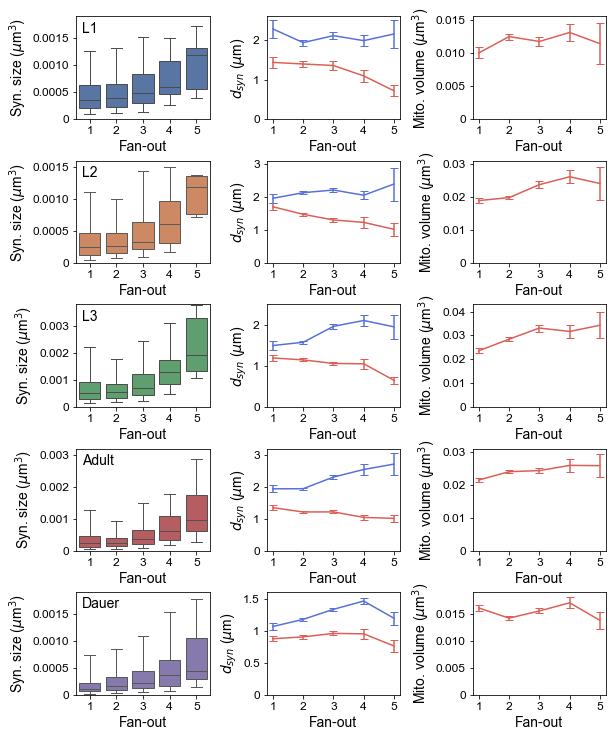

In [62]:
fig = plt.figure(figsize=(8.4,10), constrained_layout=True)
gs = fig.add_gridspec(5,3,wspace=0.05,hspace=0.01)

for i in range(5):
    ax = fig.add_subplot(gs[i,0])
    plot1(ax, synsize_pre_list[i], stage_cmap[i],
          yticks1_list[i], yticklab1_list[i], ylim1_list[i], stage_list[i])
    
for i in range(5):
    ax = fig.add_subplot(gs[i,1])
    plot2(ax, mitodist_pre_list[i], mitodist_post_list[i],
          yticks2_list[i], yticklab2_list[i], ylim2_list[i])
        
for i in range(5):
    ax = fig.add_subplot(gs[i,2])
    plot3(ax, mitovol_pre_list[i],
          yticks3_list[i], yticklab3_list[i], ylim3_list[i])
    
plt.savefig("/home/jabae/Dropbox/SNU/Research/Celegans/Cmito/figures/figure_v2/panels/figS4.svg")
plt.show()